In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
tx_deaths = pd.read_csv("05_cleaned_data/deaths_tx.csv")
tx_prescriptions = pd.read_csv("05_cleaned_data/prescriptions_tx.csv")

In [94]:
## filter to only texas (only for pre-post)

tx_deaths = tx_deaths[tx_deaths["StateName"] == "Texas"]
tx_prescriptions = tx_prescriptions[tx_prescriptions["BUYER_STATE"] == "TX"]

### helper functions 

In [95]:
# function to select only overdose records
# double check this

def select_overdose(record):

    if record == "All other non-drug and non-alcohol causes":
        return 0

    if record == "All other alcohol-induced causes":
        return 0

    if record == "All other drug-induced causes":
        return 0

    if record == "Alcohol poisonings (overdose) (X45, X65, Y15)":
        return 0

    if record == "Drug poisonings (overdose) Unintentional (X40-X44)":
        return 1

    if record == "Drug poisonings (overdose) Suicide (X60-X64)":
        return 1

    if record == "Drug poisonings (overdose) Undetermined (Y10-Y14)":
        return 1

    else:
        return "error"
    

tx_deaths["overdose"] = tx_deaths["Drug/Alcohol Induced Cause"].apply(lambda x: select_overdose(x))


# filter accordingly
tx_deaths = tx_deaths[tx_deaths["overdose"] != 0]

In [96]:
# normalize deaths over population

tx_deaths["overdose_per_100k"] = tx_deaths["Deaths"] / tx_deaths["Population"] * 100_000

In [97]:
tx_result = tx_deaths.groupby("Year")["overdose_per_100k"].sum().reset_index()

In [98]:
# create a scale for number of years before and after 2007 (target year)

def scale_years(year):
    if year == 2004:
        return -3
    if year == 2005:
        return -2
    if year == 2006:
        return -1
    if year == 2007:
        return 0
    if year == 2008:
        return 1
    if year == 2009:
        return 2
    if year == 2010:
        return 3

tx_result["year relative to policy"] = tx_result["Year"].apply(lambda x: scale_years(x))


# double check no nulls in "year relative to policy"

assert (tx_result["year relative to policy"].isnull().sum() == 0)

# doing this in case the float == int comparison causes issues

In [99]:
tx_result

,Year,overdose_per_100k,year relative to policy
0,2004.0,210.676289,-3
1,2005.0,248.943355,-2
2,2006.0,423.517095,-1
3,2007.0,280.969382,0
4,2008.0,371.347741,1
5,2009.0,404.855060,2
6,2010.0,426.309075,3


## Pre-post plot - overdoses per 100k through the years

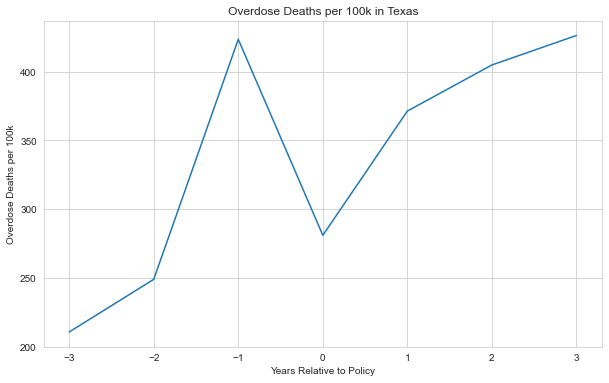

In [100]:
# plot years relative to policy vs. overdose per 100k

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.lineplot(x="year relative to policy", y="overdose_per_100k", data=tx_result)
plt.title("Overdose Deaths per 100k in Texas")
plt.xlabel("Years Relative to Policy")
plt.ylabel("Overdose Deaths per 100k")
plt.show()


## Pre-post plot - overdoses per 100k through the years

In [101]:
tx_prescriptions.head()

,REPORTER_DEA_NO,BUYER_STATE,BUYER_ZIP,BUYER_COUNTY,TRANSACTION_CODE,DRUG_CODE,DRUG_NAME,QUANTITY,TRANSACTION_DATE,Product_Name,...,CountyName,StateName,CountyFIPS,StateAbbr,STATE_COUNTY,state_abbrev,FIP_unique,State,Population,county_test
0,PB0034861,TX,75662.0,gregg,S,9193.0,HYDROCODONE,1.0,1112006.0,HYDROCODONE BIT 5MG/ACETAMINOPHEN 50,...,gregg,Texas,48183,TX,TX | GREGG,TX,4818348,TX,117118.0,Gregg
1,PL0184933,TX,75602.0,gregg,S,9193.0,HYDROCODONE,3.0,4162009.0,HYDROCODONE BITARTRATE 7.5MG/ACETAMI,...,gregg,Texas,48183,TX,TX | GREGG,TX,4818348,TX,121238.0,Gregg
2,PL0184933,TX,75602.0,gregg,S,9193.0,HYDROCODONE,2.0,4272009.0,HYDROCODONE BIT. 10MG/ACETAMINOPHEN,...,gregg,Texas,48183,TX,TX | GREGG,TX,4818348,TX,121238.0,Gregg
3,PL0184933,TX,75602.0,gregg,S,9193.0,HYDROCODONE,1.0,9242009.0,HYDROCODONE BIT. 10MG/ACETAMINOPHEN,...,gregg,Texas,48183,TX,TX | GREGG,TX,4818348,TX,121238.0,Gregg
4,PM0001951,TX,75605.0,gregg,S,9193.0,HYDROCODONE,3.0,6232008.0,HYDROCODONE BIT. 10MG/ACETAMINOPHEN,...,gregg,Texas,48183,TX,TX | GREGG,TX,4818348,TX,119157.0,Gregg


In [102]:
# groupby to find sum of quantity by year, county, and state


tx_prescriptions_copy = tx_prescriptions.groupby(["BUYER_COUNTY", "Year"])["QUANTITY"].sum().reset_index()

In [ ]:
tx_prescriptions_copy

In [ ]:
tx_prescriptions[tx_prescriptions["BUYER_COUNTY"] == "gregg"].head()

,BUYER_COUNTY,Year,QUANTITY
29,gregg,2006.0,1.0
30,gregg,2008.0,55.0
31,gregg,2009.0,6.0


In [ ]:
tx_result2 = tx_prescriptions.groupby(["Year", "Month", "QUANTITY", "BUYER_COUNTY", "BUYER_STATE"]).sum().reset_index()

KeyError: 'Month'

In [ ]:
tx_result2[
    ["Year", "Month", "QUANTITY", "BUYER_COUNTY", "Population", "CountyFIPS"]
].merge(
    tx_prescriptions,
    left_on=["Year", "Month", "CountyFIPS"],
    right_on=["Year", "Month", "CountyFIPS"],
    how="outer",
    indicator=True
)
#tx_result2.rename(columns={"Population": "population_test"})

,Year,Month,QUANTITY_x,BUYER_COUNTY_x,Population_x,CountyFIPS,REPORTER_DEA_NO,BUYER_STATE,BUYER_ZIP,BUYER_COUNTY_y,...,CountyName,StateName,StateAbbr,STATE_COUNTY,state_abbrev,FIP_unique,State,Population_y,county_test,_merge
0,2006.0,1.0,1.0,bowie,90235.0,48037,PM0001951,TX,75503.0,bowie,...,bowie,Texas,TX,TX | BOWIE,TX,4803748.0,TX,90235.0,Bowie,both
1,2006.0,1.0,1.0,el paso,744795.0,48141,PM0021131,TX,79924.0,el paso,...,el paso,Texas,TX,TX | EL PASO,TX,4814148.0,TX,744795.0,El Paso,both
2,2006.0,1.0,1.0,gregg,117118.0,48183,PB0034861,TX,75662.0,gregg,...,gregg,Texas,TX,TX | GREGG,TX,4818348.0,TX,117118.0,Gregg,both
3,2006.0,1.0,1.0,jefferson,245962.0,48245,PB0034861,TX,77706.0,jefferson,...,jefferson,Texas,TX,TX | JEFFERSON,TX,4824548.0,TX,245962.0,Jefferson,both
4,2006.0,2.0,1.0,bowie,180470.0,96074,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2008.0,9.0,NaN,NaN,NaN,48455,PM0001951,TX,75862.0,trinity,...,trinity,Texas,TX,TX | TRINITY,TX,4845548.0,TX,14380.0,Trinity,right_only
2252,2008.0,7.0,NaN,NaN,NaN,48001,PM0001951,TX,75763.0,anderson,...,anderson,Texas,TX,TX | ANDERSON,TX,4800148.0,TX,57963.0,Anderson,right_only
2253,2008.0,7.0,NaN,NaN,NaN,48001,PM0001951,TX,75763.0,anderson,...,anderson,Texas,TX,TX | ANDERSON,TX,4800148.0,TX,57963.0,Anderson,right_only
2254,2008.0,12.0,NaN,NaN,NaN,48001,PM0001951,TX,75763.0,anderson,...,anderson,Texas,TX,TX | ANDERSON,TX,4800148.0,TX,57963.0,Anderson,right_only


In [ ]:
tx_prescriptions["prescriptions per 100k"] = tx_prescriptions["overdoses"] / tx_prescriptions["population"] * 100_000

KeyError: 'overdoses'